In [2]:
#https://docs.ray.io/en/latest/serve/tutorials/pytorch.html

In [3]:
import os 
import time
import requests
from io import BytesIO
from PIL import Image

import ray
from ray import serve

import torch
import torchvision
from torchvision.transforms import ToTensor, Resize,Compose, ToPILImage
from ray_cluster_control import start_ray_cluster, stop_ray_cluster

In [4]:
start_ray_cluster("serving")

RayCluster "serving" has started
Access your cluster dashboard at http://ray-dashboard-serving-open-data-hub.apps.et-gpu.zfq7.p1.openshiftapps.com


In [5]:
@serve.deployment(route_prefix="/image_predict", name="pet_image", ray_actor_options={"num_gpus": 1})
class ImageModel:

    def __init__(self):
        self.model = torch.jit.load("best_model_scripted.pt", 
                                    map_location=torch.device('cuda:0'))
        self.preprocessor = Compose([Resize((64,64)),
                                     ToTensor()])

    async def __call__(self, starlette_request):
        image_payload_bytes = await starlette_request.body()
        pil_image = Image.open(BytesIO(image_payload_bytes))

        pil_images = [pil_image]
        input_tensor = torch.cat([self.preprocessor(i) for i in pil_images])
        input_tensor = torch.reshape(input_tensor, (1,3,64,64))
        with torch.no_grad():
            output_tensor = self.model(input_tensor.to("cuda"))

        return int(torch.argmax(output_tensor[0]))

In [6]:
os.environ['RAY_CLUSTER_NAME']

'serving'

In [7]:
ray.init('ray://{ray_head}-ray-head:10001'.format(ray_head=os.environ['RAY_CLUSTER_NAME']),
         runtime_env={"working_dir": "models/"}, _metrics_export_port=8080)

2022-10-21 16:46:08,297	INFO packaging.py:498 -- Creating a file package for local directory 'models/'.
2022-10-21 16:46:08,314	INFO packaging.py:342 -- Pushing file package 'gcs://_ray_pkg_adb6a1f9ef78e792.zip' (6.28MiB) to Ray cluster...
2022-10-21 16:46:08,440	INFO packaging.py:351 -- Successfully pushed file package 'gcs://_ray_pkg_adb6a1f9ef78e792.zip'.


Python version:,3.8.12
Ray version:,2.0.0
Dashboard:,http://10.129.4.219:8265


In [8]:
nodes = ray.nodes()
for node in nodes:
    if 'head' in node["NodeManagerHostname"]:
         host = node["NodeManagerAddress"]
print(host)

10.129.4.219


In [9]:
serve.start(http_options={"host":host})

(ServeController pid=372) INFO 2022-10-21 16:46:37,409 controller 372 http_state.py:129 - Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:FwLcPR:SERVE_PROXY_ACTOR-eaceeae0cbc58c1eb93bd57957ce4cb80231907c765ded2af31ea7eb' on node 'eaceeae0cbc58c1eb93bd57957ce4cb80231907c765ded2af31ea7eb' listening on '10.129.4.219:8000'
(HTTPProxyActor pid=404) INFO:     Started server process [404]


In [10]:
ImageModel.deploy()

(ServeController pid=372) INFO 2022-10-21 16:47:31,805 controller 372 deployment_state.py:1232 - Adding 1 replicas to deployment 'pet_image'.


In [11]:
with open("data/oxford-iiit-pet/images/Abyssinian_22.jpg", "rb") as image:
    f = image.read()
    b = bytearray(f)

In [12]:
resp = requests.post(f"http://{host}:8000/image_predict", data=b)
print(f"Predicted Class: {resp.json()}")

Predicted Class: 34


(HTTPProxyActor pid=404) INFO 2022-10-21 16:47:40,121 http_proxy 10.129.4.219 http_proxy.py:315 - POST /image_predict 200 349.1ms
(ServeReplica:pet_image pid=178, ip=10.128.2.75) INFO 2022-10-21 16:47:40,119 pet_image pet_image#PGQuGM replica.py:482 - HANDLE __call__ OK 330.5ms


In [13]:
external_route = f"http://{os.environ['SERVING_ENDPOINT']}/image_predict"
resp = requests.post(external_route, data=b)
print(f"Predicted Class: {resp.json()}")

Predicted Class: 34


(HTTPProxyActor pid=404) INFO 2022-10-21 16:47:43,653 http_proxy 10.129.4.219 http_proxy.py:315 - POST /image_predict 200 10.6ms
(ServeReplica:pet_image pid=178, ip=10.128.2.75) INFO 2022-10-21 16:47:43,651 pet_image pet_image#PGQuGM replica.py:482 - HANDLE __call__ OK 7.1ms


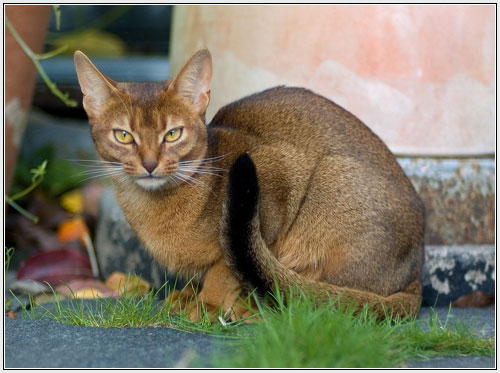

In [14]:
Image.open(BytesIO(b))

In [15]:
stop_ray_cluster("serving")

Log channel is reconnecting. Logs produced while the connection was down can be found on the head node of the cluster in `ray_client_server_[port].out`
2022-10-21 16:48:08,301	WARNING dataclient.py:395 -- Encountered connection issues in the data channel. Attempting to reconnect.


done


2022-10-21 16:48:38,506	WARNING dataclient.py:402 -- Failed to reconnect the data channel
